In [1]:
import torch

In [2]:
model_path = '../models/rnn_seq2seq_attn.pt'

In [3]:
### Select device (GPU) ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'


print('Selected device:', device)

Selected device: cuda


In [8]:
import pandas as pd

### Reading data set ###

df = pd.read_csv('../data-sets/eng-nld.txt', sep='\t', header=None, usecols=[0, 1], names=['ENG', 'NLD'], dtype='string')
df.dropna()


print(df.info())
print()
print(df.sample())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76158 entries, 0 to 76157
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ENG     76158 non-null  string
 1   NLD     76158 non-null  string
dtypes: string(2)
memory usage: 1.2 MB
None

                        ENG              NLD
17074  The roof is leaking.  Het dak is lek.


In [9]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import concurrent.futures

### Preprocessing ###

train_frac = 0.8
max_size = 20

sos_token = "<sos>"
eos_token = "<eos>"

# Define tokenization function
def tokenize(sentence):
    return [sos_token] + word_tokenize(sentence.lower()) + [eos_token]

# Define preprocessing function
def preprocess_data(data):
    # Tokenize
    data['eng_tokens'] = data['ENG'].apply(tokenize)
    data['nld_tokens'] = data['NLD'].apply(tokenize)
    
    # Trim
    data = data.drop(data[
        (data['eng_tokens'].map(len) > max_size) | 
        (data['nld_tokens'].map(len) > max_size)
    ].index)
    
    return data

# Split data function
def split_data(data):
    data = data.sample(frac=1).reset_index(drop=True)
    split = int(train_frac * len(data))
    train_data = data.iloc[:split, :]
    test_data = data.iloc[split:, :]
    test_data.reset_index(drop=True, inplace=True)
    return train_data, test_data

# Multi-threaded preprocessing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Tokenization
    tokenized_eng = executor.map(tokenize, df['ENG'])
    tokenized_nld = executor.map(tokenize, df['NLD'])
    
    # Zip tokenized lists back to DataFrame
    df['eng_tokens'] = list(tokenized_eng)
    df['nld_tokens'] = list(tokenized_nld)
    
    # Submit split_data function for execution
    future = executor.submit(split_data, df)
    
    # Retrieve the results
    train_data, test_data = future.result()

print('Total rows from file:', len(df))
print('Total rows of train data:', len(train_data))
train_data


Total rows from file: 76158
Total rows of train data: 60926


,ENG,NLD,eng_tokens,nld_tokens
0,That's all the thanks one gets.,Ondank is 's werelds loon.,"[<sos>, that, 's, all, the, thanks, one, gets,...","[<sos>, ondank, is, 's, werelds, loon, ., <eos>]"
1,Did Tom say anything about me?,Heeft Tom iets over me gezegd?,"[<sos>, did, tom, say, anything, about, me, ?,...","[<sos>, heeft, tom, iets, over, me, gezegd, ?,..."
2,Tom will explain.,Tom zal het uitleggen.,"[<sos>, tom, will, explain, ., <eos>]","[<sos>, tom, zal, het, uitleggen, ., <eos>]"
3,Tom is the culprit.,Tom is de dader.,"[<sos>, tom, is, the, culprit, ., <eos>]","[<sos>, tom, is, de, dader, ., <eos>]"
4,The boulder rolled down the hill.,De rots rolde de heuvel af.,"[<sos>, the, boulder, rolled, down, the, hill,...","[<sos>, de, rots, rolde, de, heuvel, af, ., <e..."
...,...,...,...,...
60921,I read it again.,Ik lees het nog een keer.,"[<sos>, i, read, it, again, ., <eos>]","[<sos>, ik, lees, het, nog, een, keer, ., <eos>]"
60922,Tom isn't answering.,Tom antwoordt niet.,"[<sos>, tom, is, n't, answering, ., <eos>]","[<sos>, tom, antwoordt, niet, ., <eos>]"
60923,I have already finished this book.,Ik heb dit boek al uit.,"[<sos>, i, have, already, finished, this, book...","[<sos>, ik, heb, dit, boek, al, uit, ., <eos>]"
60924,We're not teenagers anymore.,We zijn geen tieners meer.,"[<sos>, we, 're, not, teenagers, anymore, ., <...","[<sos>, we, zijn, geen, tieners, meer, ., <eos>]"


In [246]:
import torchtext

min_freq  = 2
unk_token = '<unk>'
pad_token = '<pad>'

special_tokens = [unk_token, pad_token, sos_token, eos_token]


eng_vocab = torchtext.vocab.build_vocab_from_iterator(
    df['eng_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)


nld_vocab = torchtext.vocab.build_vocab_from_iterator(
    df['nld_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)

eng_vocab.set_default_index(eng_vocab[unk_token])
nld_vocab.set_default_index(nld_vocab[unk_token])


print('Unique tokens in \'eng_tokens\' column:', len(eng_vocab))
print('Unique tokens in \'nld_tokens\' column:', len(nld_vocab))

Unique tokens in 'eng_tokens' column: 6693
Unique tokens in 'nld_tokens' column: 8551


In [247]:
import random
import numpy as np

### Vectorize data set ###

eng_pad_index = eng_vocab[pad_token]
nld_pad_index = nld_vocab[pad_token]


def build_dataset(subset):
    X = np.zeros((len(subset), max_size), dtype=np.int32)
    Y = np.zeros((len(subset), max_size), dtype=np.int32)
        
    for ix, row in subset.iterrows():
        eng_ixs = eng_vocab.lookup_indices(row['eng_tokens'])
        eng_ixs = eng_ixs + [eng_pad_index] * (max_size - len(eng_ixs))

        nld_ixs = nld_vocab.lookup_indices(row['nld_tokens'])
        nld_ixs = nld_ixs + [nld_pad_index] * (max_size - len(nld_ixs))

        X[ix] = eng_ixs
        Y[ix] = nld_ixs

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    return X, Y


Xtr, Ytr = build_dataset(train_data)
Xte, Yte = build_dataset(test_data)


print('Xtr shape:', Xtr.shape)
print()
ix = random.randint(0, len(Xtr))
print(Xtr[ix].tolist())
print(Ytr[ix].tolist())
print()
print(eng_vocab.lookup_tokens(Xtr[ix].tolist()))
print(nld_vocab.lookup_tokens(Ytr[ix].tolist()))


Xtr shape: torch.Size([60788, 20])

[2, 88, 27, 92, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 86, 28, 265, 363, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

['<sos>', 'let', 'me', 'see', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<sos>', 'laat', 'me', 'even', 'kijken', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [248]:
import torch.nn as nn

### Bidirection Encoder ###

class Encoder(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_size, n_layers=1, dropout=0):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers    = n_layers

        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim, hidden_size, n_layers, batch_first=True, dropout=dropout, bidirectional=True)

        self.dropout     = nn.Dropout(dropout)
        

    def forward(self, input):
        # input = [batch size, sequence length]

        batch_size = input.shape[0]

        embeddings = self.dropout(self.embeddings(input))
        # embeddings = [batch size, sequence length, embedding dim]

        output, hidden = self.rnn(embeddings)
        # output = [batch size, sequence length, 2 * hidden size]
        # hidden = [2 * n layers, batch size, hidden size]

        # Concat forward and backward states to obtain the annotations:
        hidden = hidden.view(self.n_layers, 2, batch_size, self.hidden_size)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        # hidden = [n layers, batch size, 2 * hidden size]

        return output, hidden

In [249]:
import torch.nn as nn
import torch.nn.functional as F

### Bahdanau Attention mechanism ###

class Attention(nn.Module):

    def __init__(self, hidden_size):
        super(Attention, self).__init__()

        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size*2, hidden_size)
        self.va = nn.Linear(hidden_size, 1, bias=False)


    def forward(self, hidden, encodings):
        # hidden    = [n layers, batch size, hidden size * 2]
        # encodings = [batch size, input sequence length, hidden size * 2]

        hidden = hidden.permute(1, 0, 2)
        # hidden = [batch size, n layers, hidden size * 2]

        sequence_length = encodings.shape[1]
        hidden = hidden[:, -1, :].unsqueeze(1).repeat(1, sequence_length, 1)
        # hidden = [batch size, input sequence length, hidden size]

        scores = self.va(torch.tanh(self.Wa(hidden) + self.Ua(encodings)))
        # scores = [batch size, input sequence length, 1]

        scores = scores.squeeze(2)
        # scores = [batch size, input sequence length]

        weights = F.softmax(scores, dim=-1)
        # weights = [batch size, input sequence length]

        weights = weights.unsqueeze(1)
        # weights = [batch size, 1, input sequence length]

        context_vector = torch.bmm(weights, encodings)
        # context_vector = [batch size, 1, hidden size * 2]

        weights = weights.squeeze(1)
        # att_weights = [batch size, Input sequence length]

        return  context_vector, weights

In [250]:
import torch.nn as nn

class Decoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_size, n_layers=1, dropout=0):
        super(Decoder, self).__init__()

        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size

        self.attention   = Attention(hidden_size)
        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim + hidden_size*2, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.fc          = nn.Linear(hidden_size, vocab_size)

        self.dropout     = nn.Dropout(dropout)


    def forward(self, input, hidden, encodings):
        # input     = [batch size]
        # hidden    = [n layers, batch size, hidden size]
        # encodings = [batch size, input sequence length, hidden size * 2]

        input = input.unsqueeze(1)
        # input = [batch size, 1]

        embeddings = self.dropout(self.embeddings(input))
        # embeddings = [batch size, 1, embedding dim]

        context_vector, att_weights = self.attention(hidden, encodings)
        # context_vector = [batch size, 1, hidden size * 2]
        # att_weights    = [batch size, input sequence length]
        
        rnn_input = torch.cat((embeddings, context_vector), dim=2)
        # rnn_input = [batch size, 1, embedding dim + hidden size * 2]

        output, hidden = self.rnn(rnn_input, hidden)
        # output = [batch size, 1, hidden size]
        # hidden = [n layers, batch size, hidden size]

        prediction = self.fc(output.squeeze(1))
        # prediction = [batch size, vocab size]

        return prediction, hidden, att_weights

In [251]:
import torch.nn as nn

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.fc_hidden = nn.Linear(encoder.hidden_size*2, decoder.hidden_size)
    
    
    def forward(self, source, target, forced_teatching_ratio=0):
        # source = [batch size, sequence length]
        # target = [batch size, sequence length]

        batch_size        = target.shape[0]
        sequence_length   = target.shape[1]
        target_vocab_size = self.decoder.vocab_size


        encodings, hidden = self.encoder(source)
        # encodings = [batch size, sequence length, 2 * hidden size]
        # hidden    = [n layers, batch size, 2 * hidden size]

        # Compute initial hidden state for the decoder
        hidden = torch.tanh(self.fc_hidden(hidden))
        # hidden    = [n layers, batch size, hidden size]

        input = target[:, 0] # first input to the decoder is the <sos> tokens
        outputs = torch.zeros(sequence_length, batch_size, target_vocab_size).to(device)
        # input = [batch size]
        # outputs = [sequence length, batch size, vocab length]
        
        for i in range(1, sequence_length):
            output, hidden, _ = self.decoder(input, hidden, encodings)
            # output = [batch size, vocab size]
            # hidden = [n layers, batch size, 2 * hidden size]

            outputs[i] = output
            
            if random.random() < forced_teatching_ratio:
                input = target[:, i] # force teach
            else:
                input = torch.argmax(output, dim=1)
        
        outputs = outputs.permute(1, 2, 0)
        # outputs = [batch size, vocab size, sequence length]
        
        return outputs


    @torch.inference_mode()
    def evaluate(self, sentence, max_output_length=20):
        self.eval()
        
        nld_sos_index = nld_vocab[sos_token]
        nld_eos_index = nld_vocab[eos_token]

        tokens = [sos_token] + word_tokenize(sentence.lower()) + [eos_token]
        ixs = eng_vocab.lookup_indices(tokens)

        tensor = torch.tensor(ixs).unsqueeze(0).to(device)
        tensor.unsqueeze(0)
        # tensor = [1, input sentence length, vocab size]

        encodings, hidden = self.encoder(tensor)
        # encodings = [1, input sequence length, 2 * hidden size]
        # hidden = [n layers, 1, 2 * hidden size]

        hidden = torch.tanh(self.fc_hidden(hidden))

        indices = [nld_sos_index]
        attentions = []
        for _ in range(max_output_length):
            inputs_tensor = torch.tensor(indices[-1]).unsqueeze(0).to(device)
            output, hidden, attention = self.decoder(inputs_tensor, hidden, encodings)
            # output =    [1, vocab size]
            # hidden =    [n layers, 1, 2 * hidden size]
            # attention = [1, input sequence]

            output = output.squeeze(0)
            # output = [vocab size]

            prediction = torch.argmax(output).item()
            
            indices.append(prediction)
            attentions.append(attention)
            
            if(prediction == nld_eos_index):
                break
        
        tokens = nld_vocab.lookup_tokens(indices)
        attentions_tensor = torch.cat(attentions)
        # attentions_tensor = [ouput sequence length - 1, input sequence length]

        return tokens, attentions_tensor

In [252]:
emb_dim     = 300
hidden_size = 512
n_layers    =   2
dropout     = 0.4

encoder = Encoder(len(eng_vocab), emb_dim, hidden_size, n_layers=n_layers, dropout=dropout)
decoder = Decoder(len(nld_vocab), emb_dim, hidden_size, n_layers=n_layers, dropout=dropout)
model   = Seq2Seq(encoder, decoder).to(device)

print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 21897079


In [253]:
import os.path

# if os.path.isfile(model_path):
#     print('Found saved model on', model_path)
#     model.load_state_dict(torch.load(dsoahnfedua;fhdiouahweiuorhq293op

In [254]:
lr = 0.00015


def forced_teaching_ratio(current_epoch, total_epochs, initial_ratio=0.9, final_ratio=0):
    # Gradually lower forced teaching ratio throughout the training
    progress = current_epoch / total_epochs
    return initial_ratio - (initial_ratio - final_ratio) * progress

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [255]:
import torch.nn.functional as F

def log_statistics(parameters, eval_batch_size=1600):
    gradients_norm = torch.tensor(
        [torch.norm(param.grad).item() for param in parameters if param.grad is not None]
    ).norm().item()
    
    inputs = torch.zeros((eval_batch_size, max_size), dtype=torch.long).to(device)
    inputs[:, 0] = nld_vocab[sos_token]

    model.eval()
    with torch.inference_mode():
    
        # Sample larger train-batch
        ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,))
        Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)
        
        outputs = model(Xb, inputs)
        loss = F.cross_entropy(outputs, Yb)

        # Sample larger test-batch
        ix = torch.randint(0, Xte.shape[0], (eval_batch_size,))
        Xb, Yb = Xte[ix].to(device), Yte[ix].to(device)

        outputs = model(Xb, inputs)
        test_loss = F.cross_entropy(outputs, Yb)
        
        return loss.item(), test_loss.item(), gradients_norm

In [256]:
from tqdm import trange

### Train network ###

epoch_count       = []
ratio_values      = []
train_loss_values = []
test_loss_values  = []
gradients_norm    = []

epochs            = 30000
batch_size        =    64


for epoch in trange(epochs):
    model.train()
    ft_ratio = forced_teaching_ratio(epoch, epochs)

    # Sample mini-batch and send to gpu
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

    output = model(Xb, Yb, ft_ratio) # Do the forward pass
    loss = criterion(output, Yb)     # Calculate the loss
    optimizer.zero_grad()            # Reset parameters
    loss.backward()                  # Backpropagation
    optimizer.step()                 # Update parameters


    # Report progression every so often
    if ((epoch + 1) % (epochs / 20) == 0):
        train_loss, test_loss, grad_norm = log_statistics(model.parameters())

        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        gradients_norm.append(grad_norm)
        ratio_values.append(ft_ratio)

 
# Print final results
print()
print('Final training loss:', round(train_loss, 3))
print('Final test loss:    ', round(test_loss, 3))

100%|██████████| 30000/30000 [32:04<00:00, 15.59it/s] 


Final training loss: 0.778
Final test loss:     1.318


In [257]:
torch.save(model.state_dict(), model_path)

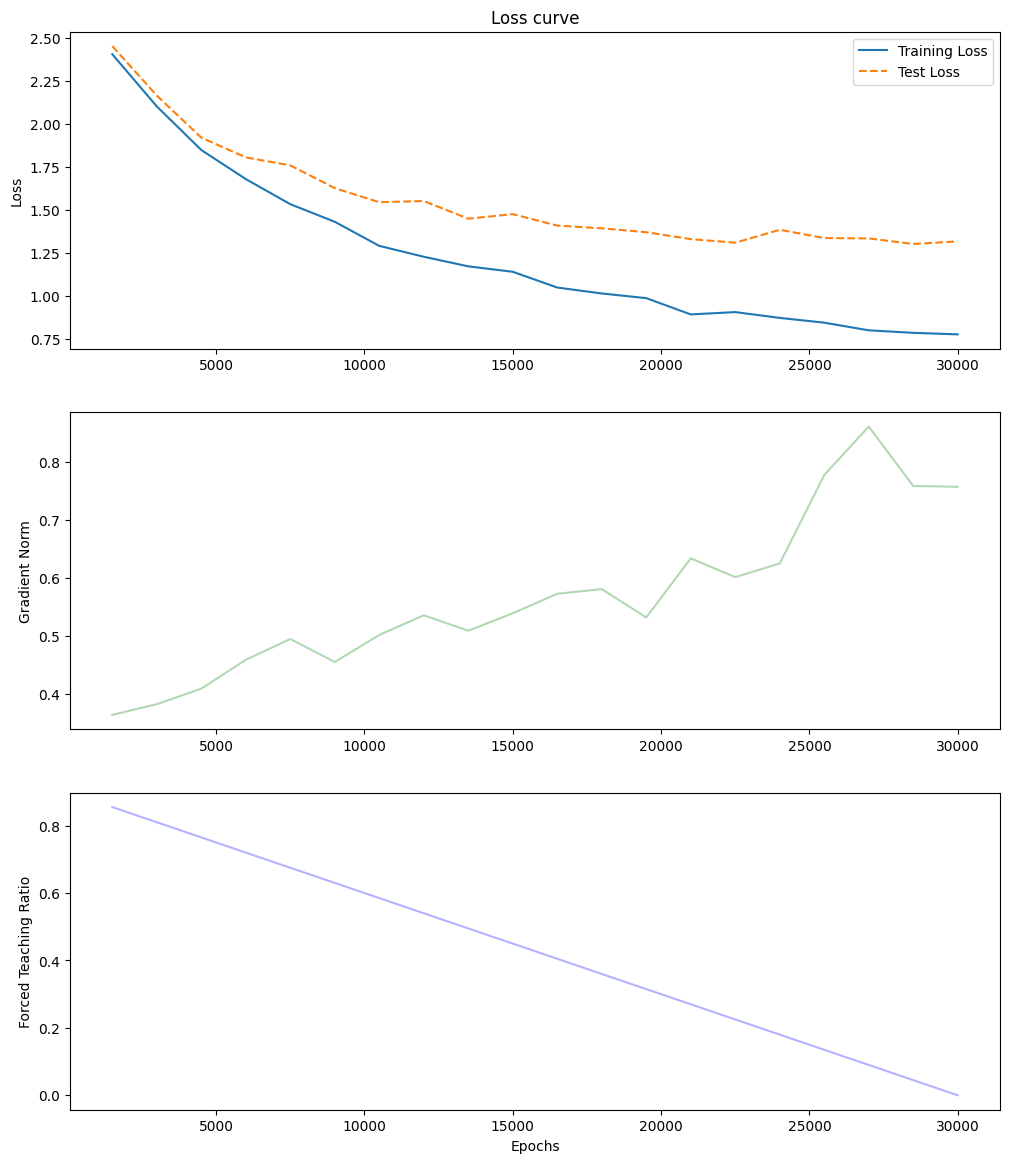

In [258]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

# Plot training and test loss on the first subplot
ax1.plot(epoch_count, train_loss_values, label='Training Loss')
ax1.plot(epoch_count, test_loss_values, label='Test Loss', linestyle='--')
ax3.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss curve')
ax1.legend(loc='upper right')

# Plot gradient norm on the second subplot
ax2.plot(epoch_count, gradients_norm, 'g', alpha=0.3)
ax3.set_xlabel('Epochs')
ax2.set_ylabel('Gradient Norm')

# Plot forced teaching ratio decay on the third subplot
ax3.plot(epoch_count, ratio_values, 'b', alpha=0.3)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Forced Teaching Ratio')

plt.show()

In [259]:
import re
from nltk import word_tokenize

def translate(sentence, max_output_length=20):
    tokens, _ = model.evaluate(sentence, max_output_length)

    tokens = [t for t in tokens if t not in (eos_token, sos_token)]
    new_sentence = ' '.join(tokens).capitalize()
    new_sentence = re.sub(r'\s+([.,!?])', r'\1', new_sentence)

    return new_sentence

In [260]:
### Use model ###

print(translate('Go!'))
print(translate('It\'s not Fine.'))
print(translate('I\'m very happy today.'))
print(translate('He\'s very sad.'))
print(translate('That man is wearing a white shirt.'))
print(translate('He\'s very afraid of spiders.'))
print(translate('He\'s going home to his wife.'))
print(translate('Those guys are walking to work.'))
print(translate('I\'m not going with you today.'))
print(translate('My girlfriend will not come over tomorrow.'))
print(translate('He bought his friends a present for christmas.'))


Ga weg!
Het is niet mee..
Ik ben erg blij vandaag vandaag.
Hij is erg jong.
Die man draagt een witte shirt.
Hij is erg bang voor spinnen.
Hij gaat naar vrouw vrouw vrouw..
Deze mensen gaan het het werk.
Ik ga vandaag niet met je..
Mijn vriendin zal morgen niet komen komen.
Hij kocht zijn vrienden een voor voor voor voor.


In [261]:
from nltk import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def evaluateAndShowAttention(input_sentence):
    output_tokens, attentions = model.evaluate(input_sentence)

    output_tokens = output_tokens[1:]

    attentions = attentions.cpu().numpy()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='plasma')
    fig.colorbar(cax)
                       
    input_tokens = [sos_token] + word_tokenize(input_sentence.lower()) + [eos_token]

    # Set up axes
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    # ax.grid(which='both', color='k', linestyle='-', linewidth=1)

    plt.show()

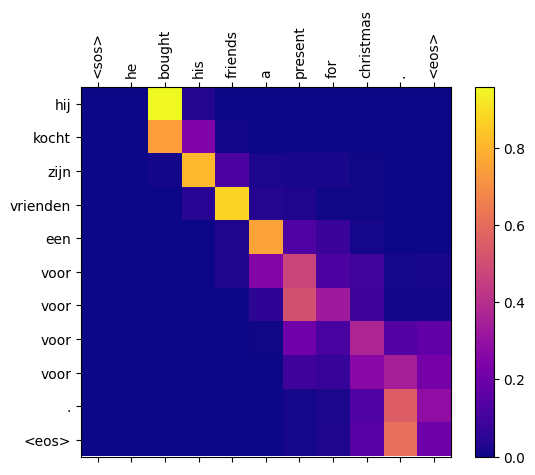

In [270]:
evaluateAndShowAttention('He bought his friends a present for christmas.')

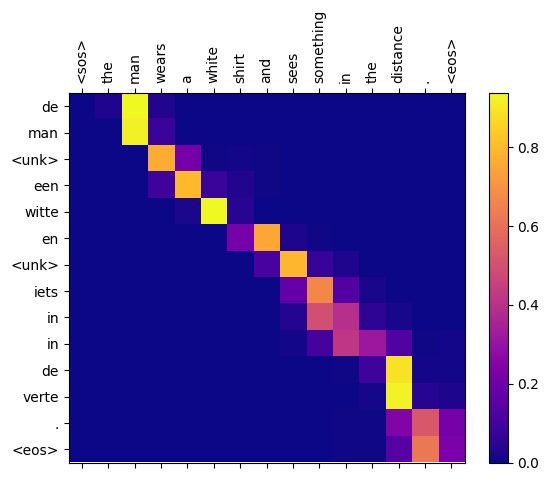

In [268]:
evaluateAndShowAttention('The man wears a white shirt and sees something in the distance.')